# Extra Material: Cutting Stock 



In [35]:
# install Pyomo and solvers
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    
SOLVER_MILO = "cbc"
SOLVER_MINLO = "couenne"
SOLVER_MIQCO = "mosek_direct"

## References

The one dimensional cutting stock problem addressed in this notebook is generally attributed to two classic papers by Gilmore and Gomory. This first paper considers the more general case of stocks available in multiple lengths, while the second paper specializes to the needs of a paper trimming operation.

> Gilmore, P. C., & Gomory, R. E. (1961). A linear programming approach to the cutting-stock problem. Operations research, 9(6), 849-859. [[jstor](https://www.jstor.org/stable/pdf/167051.pdf)]

> Gilmore, P. C., & Gomory, R. E. (1963). A linear programming approach to the cutting stock problem—Part II. Operations research, 11(6), 863-888. [[jstor](https://www.jstor.org/stable/pdf/167827.pdf)]

The solution proposed by Gilmore and Gamory has been refined over time and now generally referred to as "column generation". A number of tutorial implemenations are available, these are representative:

> * [Mathworks/Matlab: Cutting Stock Problem](https://www.mathworks.com/help/optim/ug/cutting-stock-problem-based.html)
* [AIMMS: Cutting Stock Problem](https://download.aimms.com/aimms/download/manuals/AIMMS3OM_CuttingStock.pdf)
* [SCIP:Bin packing and cutting stock problems](https://scipbook.readthedocs.io/en/latest/bpp.html)
* [PuLP: Implementation](https://github.com/coin-or/pulp/blob/master/examples/CGcolumnwise.py)

More recently, the essential bilinear structure of the problem has been noted, and various convex transformations of the problem have been studied:

> Harjunkoski, I., Westerlund, T., Pörn, R., & Skrifvars, H. (1998). Different transformations for solving non-convex trim-loss problems by MINLP. European Journal of Operational Research, 105(3), 594-603. [[abo.fi](http://users.abo.fi/twesterl/some-selected-papers/49.%20EJOR-IH-TW-RP-HS-1998.pdf)][[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0377221797000660)]

> Harjunkoski, I., Pörn, R., & Westerlund, T. (1999). Exploring the convex transformations for solving non-convex bilinear integer problems. Computers & Chemical Engineering, 23, S471-S474. [[sciencedirect](https://www.sciencedirect.com/science/article/pii/S0098135499801161)

## Problem formulation

Consider a set ${S}$ of available stock materials that can be cut to size to produce a set of finished parts. Each stock $s\in S$ is characterized by a length $l^S_s$, costs $c_s$ per piece, and is available in unlimited quantity. A customer order is received to product a set of finished products $F$. Each finished product $f\in F$ is specified by a required number $d_f$ and length $l^F_f$. The **cutting stock problem** find a minimum cost solution to fulfilling the customer order by cutting finished products from the available stocks.

This problem is illustrated is by the following tables of data for the example given by Gilmore and Gamory (1961).

**Stocks**

| stocks <br> $s$ | length <br> $l^S_s$ | cost <br> $c_s$ |
| :--: | :--: | :--: |
| A | 5 | 6 |
| B | 6 | 7 |
| C | 9 |10 |

**Finished Products**

| finished products <br> $f$ | length <br> $l^F_f$ | demand <br> $d_f$ |
| :--: | :--: | :--: |
| S | 2 | 20 |
| M | 3 | 10 |
| L | 4 | 20 |

One approach to solving this problem would be creating a list of each finished products, a list of stocks of each length, then a set of binary decision variables assigning each finished product to a particular piece of stock. The objective would be to minimize the cost of stock required to produced the finished products. This approach might work well for a very small problem, but the computational complexity scales too rapidly with the size of the problem to be a practical approach for business applications.


In [261]:
from dataclasses import dataclass
from typing import List

@dataclass
class StockItem:
    length: float
    cost: float
    
@dataclass
class FinishItem:
    length: float
    
stocks = {
    'A': StockItem(5, 6),
    'B': StockItem(6, 7),
    'C': StockItem(9, 10),
}

finish = {
    'S': FinishItem(2),
    'M': FinishItem(3),
    'L': FinishItem(4),
}


## Patterns

To address the computational complexity of the problem, Gilmore and Gamory introduced "activities" that, in more contemporary treatments, are now called patterns. A pattern $p$ in a set of patterns $P$ is represented by a set of integers $a_{fsp} \in \mathbb{Z}^+$
that specifies the number of finished products of type $f$ that are cut from stock $s\in S$. 

A pattern $p\in P$ is feasible for stock $s\in S$ if 

$$
\begin{align}
\sum_{f\in F}a_{fsp}l^F_f  & \leq   l^S_s
\end{align}
$$

The following cell presents a simple Pyomo model to produce a set of feasible patterns for given sets of stocks and finished products.


In [259]:
pattern = (
    stock['A'],
    [

TypeError: __init__() missing 1 required positional argument: 'cost'

In [158]:
import pyomo.environ as pyo

stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

# optimization problem to find a set of patterns
def make_patterns(stocks, finish, Np=(len(finish) + len(stocks))):
    
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, Np-1)

    m.a = pyo.Var(m.F, m.P, domain=pyo.NonNegativeIntegers)
    m.b = pyo.Var(m.S, m.P, domain=pyo.Binary)

    # assign as many parts as possible
    @m.Objective(sense=pyo.maximize)
    def pattern_waste(m):
        return sum(m.a[f, p] * finish[f]['length'] for f in m.F for p in m.P)

    # each pattern must fit into length of stock
    @m.Constraint(m.P)
    def feasible_pattern(m, p):
        return sum(m.a[f, p] * finish[f]['length'] for f in m.F) <= sum(m.b[s, p] * stocks[s]['length'] for s in m.S)

    # assign exactly one stock to each pattern
    @m.Constraint(m.P)
    def assign_each_stock_to_pattern(m, p):
        return sum(m.b[s, p] for s in m.S) == 1

    # assign all stocks to at least one pattern
    @m.Constraint(m.S)
    def assign_stocks_to_pattern(m, s):
        return sum(m.b[s, p] for p in m.P) >= 1

    # assign each finished product to at least one pattern
    @m.Constraint(m.F)
    def assign_each_finish_to_pattern(m, f):
        return sum(m.a[f, p] for p in m.P) >= 1

    # assign each pattern to at least one finished product
    @m.Constraint(m.P)
    def assign_each_pattern_to_finish(m, p):
        return sum(m.a[f, p] for f in m.F) >= 1

    solver = pyo.SolverFactory(SOLVER_MILO)
    solver.solve(m)

    patterns = (([s for s in m.S if m.b[s, p]() > 0][0], tuple([(f, int(m.a[f, p]() + 1e-4)) for f in m.F])) for p in m.P)
    return tuple(set(patterns))

patterns = make_patterns(stocks, finish)

patterns

(('A', (('S', 1), ('M', 1), ('L', 0))),
 ('C', (('S', 0), ('M', 3), ('L', 0))),
 ('B', (('S', 1), ('M', 0), ('L', 1))),
 ('C', (('S', 3), ('M', 1), ('L', 0))))

In [159]:
# Given a set of patterns, find minimum cost solution

def cut_stock_from_patterns(stocks, finish, patterns):
    m = pyo.ConcreteModel()

    m.STOCKS = pyo.Set(initialize=list(stocks.keys()))
    m.FINISH = pyo.Set(initialize=list(finish.keys()))
    m.PATTERNS = pyo.RangeSet(0, len(patterns)-1)

    m.x = pyo.Var(m.PATTERNS, domain=pyo.NonNegativeIntegers)

    @m.Param(m.FINISH, m.PATTERNS)
    def a(m, f, p):
        return patterns[p][1][list(m.FINISH).index(f)][1]

    @m.Objective(sense=pyo.minimize)
    def cost(m):
        return sum(stocks[patterns[p][0]]['cost'] * m.x[p] for p in m.PATTERNS)

    @m.Constraint(m.FINISH)
    def demand(m, f):
        return sum(m.a[f, p] * m.x[p] for p in m.PATTERNS) >= finish[f]['demand']

    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    solver = pyo.SolverFactory(SOLVER_MILO)
    solver.solve(m)
    print(list(m.dual[m.demand[f]] for f in m.FINISH))

    return m

m = cut_stock_from_patterns(stocks, finish, patterns)
m.demand.display()
m.x.display()
m.cost.display()

[0.0, 0.0, 0.0]
demand : Size=3
    Key : Lower : Body : Upper
      L :  20.0 : 20.0 :  None
      M :  10.0 : 10.0 :  None
      S :  20.0 : 21.0 :  None
x : Size=4, Index=PATTERNS
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :     0 :   1.0 :  None : False : False : NonNegativeIntegers
      1 :     0 :   3.0 :  None : False : False : NonNegativeIntegers
      2 :     0 :  20.0 :  None : False : False : NonNegativeIntegers
      3 :     0 :   0.0 :  None : False : False : NonNegativeIntegers
cost : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 176.0


## Cutting stock problem - bilinear reformulation

Consider the simulaneous task of finding the patterns and cuts. This forms a non-convex, mixed integer bilinear optimization problem.

$$
\begin{align}
\min & \sum_{s\in S} c_s \sum_{p\in P} x_{sp} \\
\text{s.t.}\qquad
& \sum_{f\in F}a_{fsp}l^F_f \leq l^S_s && \forall s\in S, \forall p\in P\\
& \sum_{s\in S} \sum_{p\in P}a_{fsp} x_{sp} \geq d_f && \forall f\in F\\
& a_{fsp}, x_{sp}  \in \mathbb{Z}^+ && \forall f\in F, \forall s\in S, \forall p\in P\\
\end{align}
$$

The following Pyomo model solves the problem when an upper bound $N$ on the number of patterns to be assigned to every stock is note is specified. The solution is found using an MINLO solver.

In [179]:
import pyomo.environ as pyo
import pandas as pd

def cut_stock_minlo(stocks, finish, N):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, N-1)

    m.a = pyo.Var(m.F, m.S, m.P, domain=pyo.NonNegativeIntegers)
    m.x = pyo.Var(m.S, m.P, domain=pyo.NonNegativeReals)

    # minimize cost
    @m.Objective(sense=pyo.minimize)
    def cost(m):
        return sum(stocks[s]['cost'] * m.x[s, p] for p in m.P for s in m.S)

    # each pattern must fit into length of stock
    @m.Constraint(m.S, m.P)
    def feasible_pattern(m, s, p):
        return sum(m.a[f, s, p] * finish[f]['length'] for f in m.F) <= stocks[s]['length']

    @m.Constraint(m.F)
    def demand(m, f):
        return sum(m.a[f, s, p] * m.x[s, p] for p in m.P for s in m.S) >= finish[f]['demand']

    # CUTS -- Reduces the set of possible a[f, s, p]

    # assign each finished product to at least one pattern
    @m.Constraint(m.F)
    def assign_each_finish_to_pattern(m, f):
        return sum(m.a[f, s, p] for s in m.S for p in m.P) >= 1

    # assign each pattern to at least one finished product
    @m.Constraint(m.P)
    def assign_each_pattern_to_finish(m, p):
        return sum(m.a[f, s, p] for f in m.F for s in m.S) >= 1

    return m

In [180]:
# note the bonmin returns a local solution cost=200

stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

m = cut_stock_minlo(stocks, finish, 2)
pyo.SolverFactory("bonmin").solve(m)
print(f"Cost = {m.cost():0.2f}")

Cost = 180.00


In [181]:
def cut_stock_display(m):
    for s in m.S:
        for p in m.P:
            if m.x[s, p]() >= 1e-3:
                print(f"Cut {m.x[s, p]():0.1f}: Pattern = {s}[{p}] ")
                for f in m.F:
                    print("   ", f, m.a[f, s, p]())

cut_stock_display(m)

Cut 10.0: Pattern = A[0] 
    S 1.0
    M 1.0
    L 0.0
Cut 10.0: Pattern = B[0] 
    S 1.0
    M 0.0
    L 1.0
Cut 5.0: Pattern = C[0] 
    S 0.0
    M 0.0
    L 2.0


bonmin.time_limit: 3.0
solver: 'bonmin'


In [221]:
stocks = {
    'log': {'length': 200, 'cost': 1},
}

finish = {
    1:  {'length': 75.0, 'demand': 38},
    2:  {'length': 75.0, 'demand': 44},
    3:  {'length': 75.0, 'demand': 30},
    4:  {'length': 75.0, 'demand': 41},
    5:  {'length': 75.0, 'demand': 36},
    6:  {'length': 53.8, 'demand': 33},
    7:  {'length': 53.0, 'demand': 36},
    8:  {'length': 51.0, 'demand': 41},
    9:  {'length': 50.2, 'demand': 35},
    10: {'length': 32.2, 'demand': 37},
    11: {'length': 30.8, 'demand': 44},
    12: {'length': 29.8, 'demand': 49},
    13: {'length': 20.1, 'demand': 37},
    14: {'length': 16.2, 'demand': 36},
    15: {'length': 14.5, 'demand': 42},
    16: {'length': 11.0, 'demand': 33},
    17: {'length':  8.6, 'demand': 47},
    18: {'length':  8.2, 'demand': 35},
    19: {'length':  6.6, 'demand': 49},
    20: {'length':  5.1, 'demand': 42},
}

m = cut_stock_minlo(stocks, finish, 4)
solver = pyo.SolverFactory("bonmin")
pyo.SolverFactory("bonmin").solve(m, options={"bonmin.allowable_gap": 0.3})
print(f"Cost = {m.cost():0.2f}")

cut_stock_display(m)


KeyboardInterrupt: 

In [220]:
m.pprint()

5 Set Declarations
    F : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   20 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
    S : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    1 : {'log',}
    a_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     3 :  F*S*P :   80 : {(1, 'log', 0), (1, 'log', 1), (1, 'log', 2), (1, 'log', 3), (2, 'log', 0), (2, 'log', 1), (2, 'log', 2), (2, 'log', 3), (3, 'log', 0), (3, 'log', 1), (3, 'log', 2), (3, 'log', 3), (4, 'log', 0), (4, 'log', 1), (4, 'log', 2), (4, 'log', 3), (5, 'log', 0), (5, 'log', 1), (5, 'log', 2), (5, 'log', 3), (6, 'log', 0), (6, 'log', 1), (6, 'log', 2), (6, 'log', 3), (7, 'log', 0), (7, 'log', 1), (7, 'log', 2), (7, 'log', 3), (8, 'log', 0), (8, 'log', 1), (8, 'log', 2), (8, 'log', 3), (9, 'log', 0), (9, 'lo

## False Starts -- Ignore below

$$
\begin{align}
\min & \sum_{s\in S} c_s \sum_{p\in P} x_{sp} \\
\text{s.t.}\qquad
& \sum_{f\in F}a_{fsp}l^F_f - l^S_s \leq 0 && \forall s\in S, \forall p\in P\\
& d_f - \sum_{s\in S} \sum_{p\in P}a_{fsp} x_{sp} \leq 0 && \forall f\in F\\
& a_{fsp}, x_{sp}  \in \mathbb{Z}^+ && \forall f\in F, \forall s\in S, \forall p\in P\\
\end{align}
$$

$$
\begin{align}
\mathcal{L} & = \sum_{s\in S} c_s \sum_{p\in P} x_{sp} 
+ \sum_{s\in S}\sum_{p\in P} \nu_{sp} \sum_{f\in F}\left( a_{fsp}l^F_f - l^S_s \right)
+ \sum_{f\in F} \mu_f \left(d_f - \sum_{s\in S}\sum_{p\in P}a_{fsp} x_{sp} \right)
- \sum_{f\in F} \sum_{s\in S} \sum_{p\in P} \alpha_{fsp} a_{fsp} 
- \sum_{s\in S} \sum_{p\in P} \beta_{sp} x_{sp} 
\end{align}
$$

$$
\begin{align}
\max & asd \\
\text{s.t.}\qquad
& \frac{\partial\mathcal{L}}{\partial a_{fsp}} = 0 \implies \nu_{sp}l^F_f - \mu_f x_{sp} - \alpha_{fsp} = 0\\
& \frac{\partial\mathcal{L}}{\partial x_{sp}} = 0 \implies c_s - \mu_f a_{fsp} - \beta_{sp} = 0\\
\end{align}
$$

## Cutting stock problem - MIQCO reformulation

The nonlinear character of the cutting stock problem is due to the appearance of bilinear term $a_{fsp} x_{sp}$ appearing in the demand constraint. Introducing auxiliary variables $r_{fsp}$ and the constraint  $a_{fsp} x_{sp} \geq r^2_{fsp}$ yields

$$
\begin{align}
\min & \sum_{s\in S} c_s \sum_{p\in P} x_{sp} \\
\text{s.t.}\qquad
& \sum_{f\in F}a_{fsp}l^F_f  \leq  l^S_s && \forall s\in S, \forall p\in P\\
& \sum_{s\in S} \sum_{p\in P}r^2_{fsp} \geq d_f && \forall f\in F\\
& (a_{fsp}, x_{sp}, \sqrt{2}r_{fsp}) \in Q^3_r && \forall f\in F,  \forall s\in S, \forall p\in P\\
& a_{fsp}, x_{sp}, r_{fsp}  \in \mathbb{Z}^+ && \forall f\in F,  \forall s\in S,  \forall p\in P\\
\end{align}
$$

where $Q^3_r$ is the rotated quadratic cone in three dimensions. $Q^3_r$ is defined by $(x_1, x_2, x_3) \in \mathbb{R}^3_+$ where

$$
\begin{align}
Q^3_r & = \{\ (x_1, x_2, x_3)\ |\ 2x_1 x_2 \geq x_3^2\ \}
\end{align}
$$




$$
\begin{align}
\min & \sum_{s\in S} c_s \sum_{p\in P} x_{sp} \\
\text{s.t.}\qquad
& \sum_{f\in F}a_{fsp}l^F_f  \leq  l^S_s && \forall s\in S, \forall p\in P\\
& \sum_{s\in S} \sum_{p\in P} r_{fsp} x_{p}  \leq N_s N_p M - d_f && \forall f\in F\\
& a_{fsp} = M - r_{fsp}  && \forall f\in F, \forall s\in S, \forall p\in P\\
& a_{fsp}, x_{sp}  \in \mathbb{Z}^+ && \forall f\in F, \forall s\in S, \forall p\in P\\
\end{align}
$$

In [39]:
import pyomo.kernel as pmo
import pyomo.environ as pyo

def cut_stock_miqco(stocks, finish, N):
    m = pmo.block()

    m.F = list(finish.keys())
    m.S = list(stocks.keys())
    m.P = list(range(N))

    m.a = pmo.variable_dict()
    m.r = pmo.variable_dict()
    m.x = pmo.variable_dict()
    
    for p in m.P:
        for s in m.S:
            m.x[s, p] = pmo.variable(domain=pmo.IntegerSet, lb=0)
            for f in m.F:
                m.a[f, s, p] = pmo.variable(domain=pmo.IntegerSet, lb=0)
                m.r[f, s, p] = pmo.variable(domain=pmo.IntegerSet, lb=0)
                
    m.cost = pmo.objective(sum(stocks[s]['cost'] * sum(m.x[s, p] for p in m.P) for s in m.S))
    
    m.feasible = pmo.constraint_dict()
    for s in m.S:
        for p in m.P:
            body = sum(m.a[f, s, p] * finish[f]['length'] for s in m.S)
            m.feasible[s, p] = pmo.constraint(body <= stocks[s]['length'])
            
    m.demand = pmo.constraint_dict()
    for f in m.F:
        m.demand[f] = pmo.constraint(sum((10 - m.r[f, s, p])**2 for s in m.S for p in m.P) >= finish[f]['demand'])
       
    pyo.SolverFactory(SOLVER_MIQCO).solve(m)

    return m


stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

m = cut_stock_miqco(stocks, finish, 2)
#print(f"Cost = {m.cost():0.2f}")
print(m.cost())

ERROR: rescode.err_con_q_not_nsd(1294): The constraint 'x49'(6) is not convex.
    Q should be negative semidefinite for a constraint with finite lower
    bound.


Error: rescode.err_con_q_not_nsd(1294): The constraint 'x49'(6) is not convex. Q should be negative semidefinite for a constraint with finite lower bound.


To address computational complexity, a key insight from Gilmore and Gamory (1961) is to add to the formulation a finite set $P$ of **cutting patterns**. A cutting pattern $p\in P$ specifies an integer number $a_{fp}$ of items of each finished product $f\in F$ that can be cut from the particular stock  assigned to that pattern. Let $b_{sp}$ be a binary variable indicating stock $s\in S$ is assigned to pattern $p$. Exactly one stock must be assigned to each pattern, therefore

$$
\begin{align}
\sum_{s\in S}b_{sp}  & =  1 & \forall p\in P
\end{align}
$$

A pattern $p\in P$ specified by parameters $a_{fp}$ and $b_{sp}$ is feasible if 

$$
\begin{align}
\sum_{f\in F}a_{fp}l^F_f  & \leq  \sum_{s\in S} b_{sp} l^S_s & \forall p\in P
\end{align}
$$

An auxiliary constraint ensures that finished product appears in at least one pattern.

Given a set of patterns, the order is fulfilled if 

$$
\begin{align}
\sum_{p\in P}a_{fp} x_{p} & \geq d_f & \forall f\in F
\end{align}
$$

where $x_{p}$ is the integer number of times pattern $p\in P$ is used.

The cost of fulfilling the customer order is then given by

$$
\begin{align}
\text{C} & = \sum_{p\in P}\left(\sum_{s\in S}c_{s} b_{sp}\right) x_{p}
\end{align}
$$




Given a set of patterns, the order is fulfilled if 

$$
\begin{align}
\sum_{p\in P}a_{fp} x_{p} & \geq d_f & \forall f\in F
\end{align}
$$

where $x_{p}$ is the integer number of times pattern $p\in P$ is used.

The cost of fulfilling the customer order is then given by

$$
\begin{align}
\text{C} & = \sum_{p\in P}\left(\sum_{s\in S}c_{s} b_{sp}\right) x_{p}
\end{align}
$$

## Cutting stock problem

$$
\begin{align}
\min & \sum_{p\in P} \sum_{s\in S}c_{s} b_{sp} x_{p} \\
\text{s.t.}\qquad
& \sum_{s\in S}b_{sp} =  1 && \forall p\in P \\
& \sum_{f\in F}a_{fp}l^F_f  \leq \sum_{s\in S} b_{sp} l^S_s && \forall p\in P \\
& \sum_{p\in P}a_{fp} x_{p} \geq d_f && \forall f\in F\\
& a_{fp}, b_{sp}, x_p  \in \mathbb{Z}^+ && \forall f\in F,  \forall p\in P,  \forall s\in S  \\
\end{align}
$$




In [111]:
import pyomo.environ as pyo
import pandas as pd

def pattern_model_minlp(stocks, finish, N):
    m = pyo.ConcreteModel()

    m.S = pyo.Set(initialize=list(stocks.keys()))
    m.F = pyo.Set(initialize=list(finish.keys()))
    m.P = pyo.RangeSet(0, N-1)

    m.a = pyo.Var(m.F, m.P, bounds=(0, None)) #domain=pyo.NonNegativeIntegers)
    m.b = pyo.Var(m.S, m.P, domain=pyo.Binary)

    # relaxation of integer constraint
    m.x = pyo.Var(m.P, domain=pyo.NonNegativeIntegers)

    # minimize cost
    @m.Objective(sense=pyo.minimize)
    def cost(m):
        return sum(stocks[s]['cost'] * m.b[s, p] * m.x[p] for s in m.S for p in m.P)

    # assign exactly one stock to each pattern
    @m.Constraint(m.P)
    def assign_each_stock_to_pattern(m, p):
        return sum(m.b[s, p] for s in m.S) == 1

    # each pattern must fit into length of stock
    @m.Constraint(m.P)
    def feasible_pattern(m, p):
        return sum(m.a[f, p] * finish[f]['length'] for f in m.F) <= sum(m.b[s, p] * stocks[s]['length'] for s in m.S)

    @m.Constraint(m.F)
    def demand(m, f):
        return sum(m.a[f, p] * m.x[p] for p in m.P) >= finish[f]['demand']

    pyo.SolverFactory('bonmin').solve(m)

    df = pd.DataFrame([
        {"x_p": round(m.x[p](), 1),"Stock": [s for s in m.S if m.b[s, p]() > 0][0]}  
        | {f: int(m.a[f, p]() + 1e-4) for f in m.F} for p in m.P])

    return m, df

stocks = {
    'A': {'length': 5, 'cost': 6},
    'B': {'length': 6, 'cost': 7},
    'C': {'length': 9, 'cost': 10},
}

finish = {
    'S': {'length': 2, 'demand': 20},
    'M': {'length': 3, 'demand': 10},
    'L': {'length': 4, 'demand': 20},
}

m, df = pattern_model_minlp(stocks, finish, 3)
print(f"Cost = {m.cost():0.2f}")
display(df)

Cost = 167.00


,x_p,Stock,S,M,L
0,1.0,B,0,0,0
1,16.0,C,1,0,1
2,0.0,C,0,0,2


In [ ]:
stocks = {
    'log': {'length': 40, 'cost': 1},
}

finish = {
    'A': {'length':  8, 'demand':  90},
    'B': {'length': 12, 'demand': 111},
    'C': {'length': 16, 'demand':  55},
    'D': {'length': 20, 'demand':  30}
}

m = pattern_model_reformulated(stocks, finish, 3)
print(f"Cost = {m.cost():0.2f}")


88.50000000000001


In [ ]:
stocks = {
    'log': {'length': 200, 'cost': 1},
}

finish = {
    1:  {'length': 75.0, 'demand': 38},
    2:  {'length': 75.0, 'demand': 44},
    3:  {'length': 75.0, 'demand': 30},
    4:  {'length': 75.0, 'demand': 41},
    5:  {'length': 75.0, 'demand': 36},
    6:  {'length': 53.8, 'demand': 33},
    7:  {'length': 53.0, 'demand': 36},
    8:  {'length': 51.0, 'demand': 41},
    9:  {'length': 50.2, 'demand': 35},
    10: {'length': 32.2, 'demand': 37},
#    11: {'length': 30.8, 'demand': 44},
#    12: {'length': 29.8, 'demand': 49},
#    13: {'length': 20.1, 'demand': 37},
#    14: {'length': 16.2, 'demand': 36},
#    15: {'length': 14.5, 'demand': 42},
#    16: {'length': 11.0, 'demand': 33},
#    17: {'length':  8.6, 'demand': 47},
#    18: {'length':  8.2, 'demand': 35},
#    19: {'length':  6.6, 'demand': 49},
#    20: {'length':  5.1, 'demand': 42},
}

m = pattern_model_reformulated(stocks, finish, 4)
print(f"Cost = {m.cost():0.2f}")
 

Cost = 136.00


## Convex Model

$a_{fp}x_p \geq r^2_{fp}$ 

$$
\begin{align}
\min & \sum_{p\in P} \sum_{s\in S}c_{s} b_{sp} x_{p} \\
\text{s.t.}\qquad
& \sum_{s\in S}b_{sp} =  1 && \forall p\in P \\
& \sum_{f\in F}a_{fp}l^F_f  \leq \sum_{s\in S} b_{sp} l^S_s && \forall p\in P \\
& \sum_{p\in P}r^2_{fp} \geq d_f && \forall f\in F\\
& (a_{fp}, x_p, \sqrt{2}r_p) \in \mathcal{Q}^3_r && \forall f\in F, \forall p\in P\\
& a_{fp}, b_{sp}, x_p  \in \mathbb{Z}^+ && \forall f\in F,  \forall p\in P,  \forall s\in S  \\
\end{align}
$$




## Read problem data from Google sheets

https://docs.google.com/spreadsheets/d/1ZX7KJ2kwTGgyqEv_a3LOG0nQSxsc38Ykk53A7vGWAFU/edit#gid=1104632299

In [ ]:
import pandas as pd

def read_google_sheet(sheet_id, sheet_name):
    """
    Reads a Google Sheet and returns a pandas DataFrame.

    This function reads a Google Sheet with the specified sheet ID and sheet name,
    and returns a pandas DataFrame with the data. The column names are converted to
    lowercase.

    Args:
        sheet_id (str): The Google Sheet ID.
        sheet_name (str): The name of the sheet to read.

    Returns:
        df (pd.DataFrame): A pandas DataFrame containing the data from the Google Sheet.
    """
    url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
    df = pd.read_csv(url)
    df.columns = map(str.lower, df.columns)
    return df

In [ ]:
# Google Sheet ID
sheet_id = "1ZX7KJ2kwTGgyqEv_a3LOG0nQSxsc38Ykk53A7vGWAFU"

# read settings
settings = read_google_sheet(sheet_id, "settings")
print("\nSettings")
display(settings)

# read parts
products = read_google_sheet(sheet_id, "products")
print("\nParts")
display(parts)

# read and display stocks
stocks = read_google_sheet(sheet_id, "stocks")
#stocks = stocks.drop(["price"], axis=1)
if not "price" in stocks.columns:
    stocks["price"] = stocks["length"]
print("\nStocks")
display(stocks)


Settings


,setting,value
0,kerf,0.125



Parts


,kind,length,quantity,label
0,2x4,29,8,legs
1,2x4,48,4,long aprons
2,2x4,18,4,short aprons
3,2x6,54,8,table top



Stocks


,kind,length,price
0,2x4,36,1.68
1,2x4,48,1.86
2,2x4,72,2.57
3,2x4,84,2.65
4,2x4,96,2.92
5,2x4,120,3.67
6,2x4,144,4.40
7,2x4,168,5.14
8,2x4,192,6.92
9,2x4,216,8.62


## Create Python data structures



In [ ]:
kerf = settings.loc[0, "value"]
print(f"kerf = {kerf}")

kerf = 0.125


In [ ]:
# dictionary of all parts indexed by unique key 
part_dict = {}
for p in parts.index:
    t = (parts.loc[p, "kind"], parts.loc[p, "length"], parts.loc[p, "label"])
    part_dict[t] = parts.loc[p, "quantity"]

part_dict

{('2x4', 29, 'legs'): 8,
 ('2x4', 48, 'long aprons'): 4,
 ('2x4', 18, 'short aprons'): 4,
 ('2x6', 54, 'table top'): 8}

In [ ]:
# dictionary of stocks indexed by unique key
stock_dict = {}
for s in stocks.index:
    t = (stocks.loc[s, "kind"], stocks.loc[s, "length"])
    stock_dict[t] = stocks.loc[s, "price"]

stock_dict

{('2x4', 36): 1.68,
 ('2x4', 48): 1.86,
 ('2x4', 72): 2.57,
 ('2x4', 84): 2.65,
 ('2x4', 96): 2.92,
 ('2x4', 120): 3.67,
 ('2x4', 144): 4.4,
 ('2x4', 168): 5.14,
 ('2x4', 192): 6.92,
 ('2x4', 216): 8.62,
 ('2x4', 240): 10.4,
 ('2x6', 96): 4.43,
 ('2x6', 192): 9.36}

## Patterns

A pattern contains references to a stock time, and to a collection of parts that can be cut from the stock item.

In [ ]:
k = 0
pattern_list = []
for stock in sorted(stock_dict.keys()):
    for part in sorted(part_dict.keys()):
        if part[0] == stock[0]:
            n = round((stock[1] + kerf) // (part[1] + kerf), 0)
            if n > 0:
                pattern_list.append({"stock": stock, "parts": {part: int(n)}})
                k += 1

pattern_list

[{'stock': ('2x4', 36), 'parts': {('2x4', 18, 'short aprons'): 1}},
 {'stock': ('2x4', 36), 'parts': {('2x4', 29, 'legs'): 1}},
 {'stock': ('2x4', 48), 'parts': {('2x4', 18, 'short aprons'): 2}},
 {'stock': ('2x4', 48), 'parts': {('2x4', 29, 'legs'): 1}},
 {'stock': ('2x4', 48), 'parts': {('2x4', 48, 'long aprons'): 1}},
 {'stock': ('2x4', 72), 'parts': {('2x4', 18, 'short aprons'): 3}},
 {'stock': ('2x4', 72), 'parts': {('2x4', 29, 'legs'): 2}},
 {'stock': ('2x4', 72), 'parts': {('2x4', 48, 'long aprons'): 1}},
 {'stock': ('2x4', 84), 'parts': {('2x4', 18, 'short aprons'): 4}},
 {'stock': ('2x4', 84), 'parts': {('2x4', 29, 'legs'): 2}},
 {'stock': ('2x4', 84), 'parts': {('2x4', 48, 'long aprons'): 1}},
 {'stock': ('2x4', 96), 'parts': {('2x4', 18, 'short aprons'): 5}},
 {'stock': ('2x4', 96), 'parts': {('2x4', 29, 'legs'): 3}},
 {'stock': ('2x4', 96), 'parts': {('2x4', 48, 'long aprons'): 1}},
 {'stock': ('2x4', 120), 'parts': {('2x4', 18, 'short aprons'): 6}},
 {'stock': ('2x4', 120)

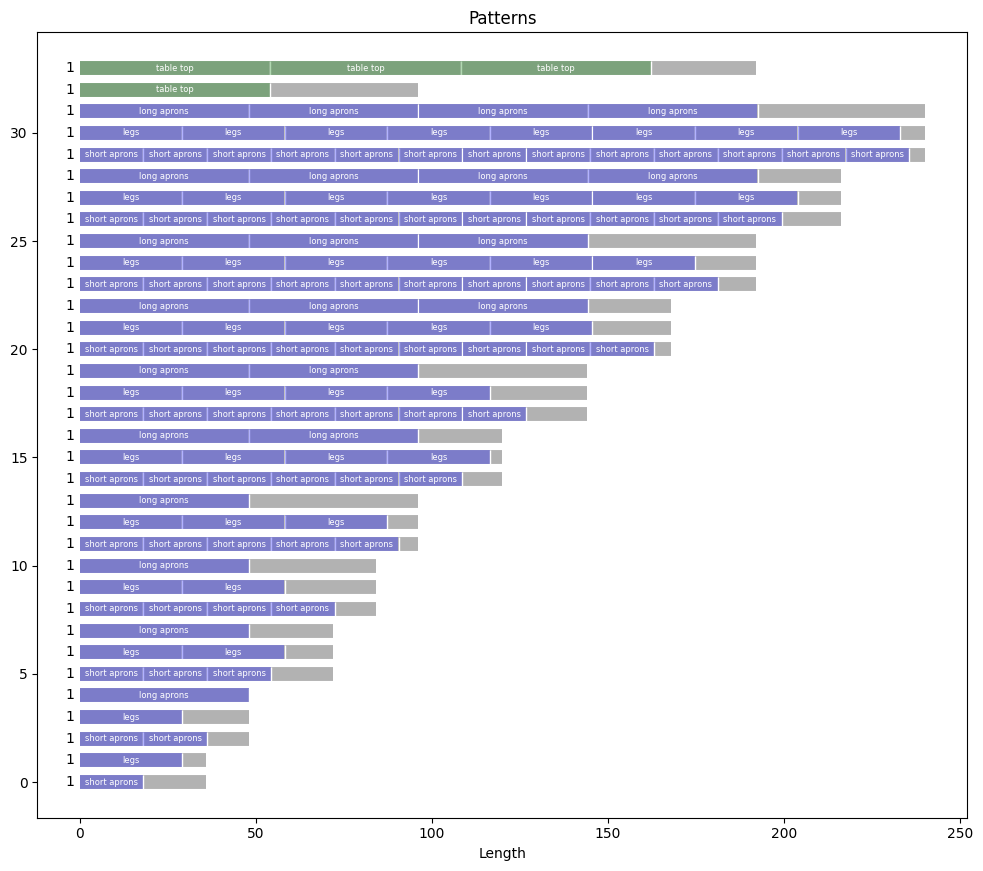

In [ ]:
import matplotlib.pyplot as plt

def plot_patterns(pattern_list, qty=[1]*len(pattern_list), kerf=kerf):
    lw = 10
    colors = {'2x4': 'b', '2x6': 'g'}
    fig, ax = plt.subplots(1, 1, figsize=(12, 0.3*len(qty)))
    k = 0
    for k, pattern in enumerate(pattern_list):
        kind, length = pattern['stock']
        n = f"{int(qty[k])} " if qty[k] > 0 else ""
        ax.text(0, k, n, ha="right", va="center")
        ax.plot((0, length), (k, k),   solid_capstyle="butt", color="k", lw=lw, alpha=0.3)
        xa = 0
        for part, qty_parts in pattern['parts'].items():
            kind, length, label = part
            for q in range(qty_parts):
                xb = xa + length
                ax.plot((xa, xb), (k, k), solid_capstyle="butt", color=colors[kind], lw=lw, alpha=0.3)
                ax.text((xa + xb)/2, k, label, fontsize=6, color="w", ha="center", va="center")
                ax.plot(xb + kerf/2, k, '|', ms=10, color="w")
                xa = xb + kerf

    ax.set_xlabel("Length")
    ax.set_title("Patterns")

plot_patterns(pattern_list)

## Model

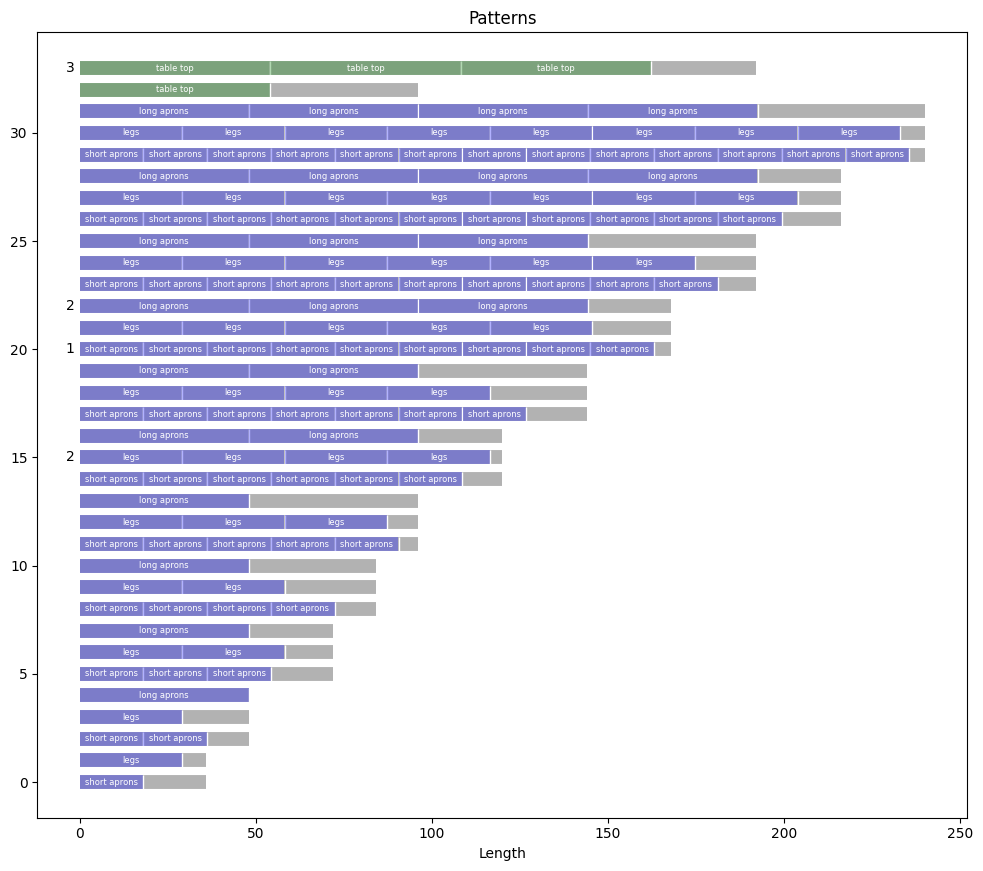

In [ ]:
import pyomo.environ as pyo
import math

def cutting_stock(part_dict, stock_dict, pattern_list):

    m = pyo.ConcreteModel()

    m.PATTERNS = pyo.RangeSet(0, len(pattern_list)-1)
    m.STOCKS = pyo.Set(initialize=list(stock_dict.keys()))
    m.PARTS = pyo.Set(initialize=list(part_dict.keys()))

    @m.Param(m.PARTS)
    def quantity(m, kind, length, label):
        return part_dict[(kind, length, label)]

    @m.Param(m.STOCKS)
    def price(m, kind, length):
        return stock_dict[(kind, length)]

    # m.x[p] = number of times to use pattern p
    m.x = pyo.Var(m.PATTERNS, bounds=(0, None))

    @m.Objective()
    def cost(m):
        return sum(m.x[k] * m.price[pattern_list[k]['stock']] for k in m.PATTERNS)

    @m.Constraint(m.PARTS)
    def sum_parts(m, kind, length, label):
        p = (kind, length, label)
        keys = [k for k in m.PATTERNS if p in pattern_list[k]['parts'].keys()]
        return sum(m.x[k] * pattern_list[k]['parts'][p] for k in keys) >=  m.quantity[p]

    m.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

    solver = pyo.SolverFactory("appsi_highs")
    solver.solve(m)

    dual_dict = {part: m.dual[m.sum_parts[part]] for part in m.PARTS}

    return [m.x[k]() for k in m.PATTERNS], dual_dict

qty, dual_dict = cutting_stock(part_dict, stock_dict, pattern_list)
qty = list(map(math.ceil, qty))
plot_patterns(pattern_list, qty)




In [ ]:
print(dual_dict)

d = pyo.ConcreteModel()
d.PARTS = pyo.Set(initialize=list(dual_dict.keys()))
d.STOCKS = pyo.Set(initialize=list(stock_dict.keys()))

d.y = pyo.Var(d.STOCKS, d.PARTS, domain=pyo.NonNegativeIntegers, bounds=(0, None))

@d.Objective(sense=pyo.maximize)
def value(d):
    return 1 # sum(dual_dict[part] * d.y[stock, part] for part in d.PARTS for stock in d.STOCKS)

@d.Constraint(d.STOCKS)
def raw(d, kind, length):
    return sum(d.y[(kind, length), part] * (part[1] + kerf) for part in d.PARTS if part[0] == kind) <= length + kerf

solver = pyo.SolverFactory('appsi_highs')
solver.solve(d)



d.pprint()

{('2x4', 29, 'legs'): 0.9175, ('2x4', 48, 'long aprons'): 1.7133333333333332, ('2x4', 18, 'short aprons'): 0.5711111111111111, ('2x6', 54, 'table top'): 3.1199999999999997}
3 Set Declarations
    PARTS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     3 :    Any :    4 : {('2x4', 29, 'legs'), ('2x4', 48, 'long aprons'), ('2x4', 18, 'short aprons'), ('2x6', 54, 'table top')}
    STOCKS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   13 : {('2x4', 36), ('2x4', 48), ('2x4', 72), ('2x4', 84), ('2x4', 96), ('2x4', 120), ('2x4', 144), ('2x4', 168), ('2x4', 192), ('2x4', 216), ('2x4', 240), ('2x6', 96), ('2x6', 192)}
    y_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain       : Size : Members
        None :     5 : STOCKS*PARTS :   52 : {('2x4', 36, '2x4', 29, 'legs'), ('2x4', 36, '2x4', 48, 'long aprons'), ('2x4', 36, '2x4', 18, 'short aprons